# Stock Sentiment Analysis and Recommendation Model
- Analysing text sentiments and providing stock recommendation

In [16]:
# Requirements
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import re

# import warnings

# warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Model Training 

In [17]:
"""
The class StockSentimentAnalyzer analyzes the sentiment of stock-related text data. 

It has several methods:
1. extract_tickers: Extracts stock tickers from text data.
2. preprocess_text: Cleans and preprocesses text data.
3. train_model: Trains a sentiment analysis model using a dataset.
4. analyze_stock_sentiments: Analyzes the sentiment of each stock ticker in a dataset.
5. predict_sentiment: Predicts the sentiment of new text data.
6. generate_recommendations: Generates top stock recommendations based on sentiment analysis.

The class uses various techniques, including:
- TF-IDF vectorization for text feature extraction
- Logistic regression for sentiment analysis
- Regular expressions for ticker extraction
- Data preprocessing and cleaning
- Sentiment scoring and confidence calculation

The model loads the dataset from Datasets/Sentiment Data/stock_sentiment_data.csv
The dataset includes columns -> Text and Sentiment, 
The Text column contain tweets, people opinion and reviews for various different stocks including their ticker name,
The Sentiment column has sentiment scores for 1 being positive and -1 being negative 
This data is further used to generate stock recommendations based on sentiment analysis.

About the data: Stock-Market Sentiment Dataset from Kaggle (link-> https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset)
Description:
- Gathered Stock news from Multiple twitter Handles regarding Economic news dividing into two parts : Negative(-1) and positive(1) .
- Negative count: 2,106
- Positive count: 3,685
"""

class StockSentimentAnalyzer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
        self.model = LogisticRegression(random_state=42)
        self.ticker_extractor = re.compile(r'\b[A-Z]{2,5}\b')
        self.stock_sentiments = defaultdict(list)
        
    def extract_tickers(self, text):
        """Extract stock tickers from text"""
        # Common stock ticker patterns
        tickers = self.ticker_extractor.findall(text.upper())
        # Filter out common words that might be mistaken for tickers
        common_words = {'THE', 'AND', 'FOR', 'ARE', 'BUT', 'NOT', 'YOU', 'ALL', 'CAN', 'HER', 'WAS', 'ONE', 'OUR', 'HAD', 'BUT', 'HAS', 'HIS', 'TWO', 'NOW', 'WAY', 'WHO', 'ITS', 'NEW', 'USE', 'MAN', 'DAY', 'GET', 'OWN', 'SAY', 'SHE', 'HOW', 'HIM', 'OLD', 'SEE', 'NOW', 'WAY', 'MAY', 'TWO', 'OUT', 'TOP', 'PUT', 'END', 'WHY', 'TRY', 'GOD', 'SIX', 'DOG', 'EAT', 'AGO', 'SIT', 'FUN', 'BAD', 'YES', 'YET', 'ARM', 'FAR', 'OFF', 'BAG', 'BIG', 'BOX', 'CUT', 'FEW', 'LOT', 'RUN', 'SET', 'WIN', 'LET', 'RED', 'HOT', 'BIT', 'GOT', 'TOO', 'ADD', 'MAP', 'CAR', 'JOB', 'WAR', 'LAW', 'AGE', 'BOY', 'DID', 'FIX', 'OIL', 'SUN', 'ART', 'BED', 'EYE', 'FLY', 'GUN', 'HIE', 'JOY', 'KEY', 'LAY', 'MOM', 'PAY', 'ROW', 'TEA', 'VAN', 'ZIP'}
        return [ticker for ticker in tickers if ticker not in common_words and len(ticker) <= 5]
    
    def preprocess_text(self, text):
        """
        Clean and preprocess text
        1. Removes user mentions (e.g., @username) and URLs from the text.
        2. Removes non-alphabetic characters (except spaces) from the text.
        3. Joins split words back together with a single space.
        4. Converts the text to lowercase.
        The goal is to prepare the text for further analysis or processing, such as sentiment analysis or text classification.
        """
        # Remove user mentions and URLs
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = ' '.join(text.split())
        return text.lower()
    
    def train_model(self, df):
        """Training the sentiment analysis model with LogisticRegression"""
        print("Training sentiment analysis model...")
        
        # Preprocess texts
        df['cleaned_text'] = df['Text'].apply(self.preprocess_text)
        
        # Extract features
        X = self.vectorizer.fit_transform(df['cleaned_text'])
        y = df['Sentiment']
        
        # Split data 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train model
        self.model.fit(X_train, y_train)
        
        # Evaluate model
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model Accuracy: {accuracy:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Negative', 'Positive'], 
                   yticklabels=['Negative', 'Positive'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return accuracy
    
    def analyze_stock_sentiments(self, df):
        """Analyze sentiment for each stock ticker"""
        print("Analyzing stock sentiments...")
        
        stock_data = []
        self.stock_sentiments = defaultdict(list)  # Store individual sentiments for each ticker
        
        for idx, row in df.iterrows():
            text = row['Text']
            sentiment = row['Sentiment']
            tickers = self.extract_tickers(text)
            
            for ticker in tickers:
                stock_data.append({
                    'ticker': ticker,
                    'sentiment': sentiment,
                    'text': text
                })
                # Store individual sentiment for each ticker
                self.stock_sentiments[ticker].append(sentiment)
        
        stock_df = pd.DataFrame(stock_data)
        
        if len(stock_df) == 0:
            print("No stock tickers found in the data.")
            return pd.DataFrame()
        
        # Aggregate sentiment by ticker
        sentiment_summary = stock_df.groupby('ticker').agg({
            'sentiment': ['count', 'mean', 'sum'],
            'text': 'count'
        }).round(3)
        
        sentiment_summary.columns = ['mention_count', 'avg_sentiment', 'total_sentiment', 'text_count']
        sentiment_summary = sentiment_summary.reset_index()
        
        # Filter tickers with at least 2 mentions
        sentiment_summary = sentiment_summary[sentiment_summary['mention_count'] >= 2]
        
        return sentiment_summary.sort_values('avg_sentiment', ascending=False)
    
    def predict_sentiment(self, text):
        """Predict sentiment for new text"""
        cleaned_text = self.preprocess_text(text)
        text_vectorized = self.vectorizer.transform([cleaned_text])
        prediction = self.model.predict(text_vectorized)[0]
        probability = self.model.predict_proba(text_vectorized)[0]
        
        return {
            'prediction': prediction,
            'confidence': max(probability),
            'probabilities': {
                'negative': probability[0] if self.model.classes_[0] == -1 else probability[1],
                'positive': probability[1] if self.model.classes_[1] == 1 else probability[0]
            }
        }
    
    def generate_recommendations(self, sentiment_summary, top_n=5):
        """Generate top 5 stock recommendations with specified columns"""
        if len(sentiment_summary) == 0:
            return pd.DataFrame()
        
        # Calculate sentiment score (normalized between 0-1)
        sentiment_summary['sentiment_score'] = (sentiment_summary['avg_sentiment'] + 1) / 2
        
        # Calculate confidence based on mention count and sentiment consistency
        max_mentions = sentiment_summary['mention_count'].max()
        sentiment_summary['confidence'] = (
            (sentiment_summary['mention_count'] / max_mentions) * 0.6 + 
            abs(sentiment_summary['avg_sentiment']) * 0.4
        )
        
        # Sort by sentiment score (descending) and confidence (descending)
        recommendations = sentiment_summary.sort_values(
            ['sentiment_score', 'confidence'], 
            ascending=[False, False]
        ).head(top_n)
        
        # Create final output with specified column names
        final_recommendations = pd.DataFrame({
            'Ticker': recommendations['ticker'],
            'Positive': recommendations.apply(lambda row: 
                len([s for s in self.stock_sentiments.get(row['ticker'], []) if s == 1]), axis=1),
            'Negative': recommendations.apply(lambda row: 
                len([s for s in self.stock_sentiments.get(row['ticker'], []) if s == -1]), axis=1),
            'Count': recommendations['mention_count'],
            'Sentiment Score': recommendations['sentiment_score'].round(3),
            'Confidence': recommendations['confidence'].round(3)
        })
        
        return final_recommendations.reset_index(drop=True)

#### Loading Dataset and Information

In [18]:
# Loading Dataset
df = pd.read_csv('../Datasets/Sentiment Data/stock_sentiment_data.csv')
df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [19]:
# Dataset Info
print(f'Dataset Overview:\nTotal Records: {len(df)}\nColumns: {list(df.columns)}\nFirst 10 Rows:\n{df.head(10)}')

Dataset Overview:
Total Records: 5791
Columns: ['Text', 'Sentiment']
First 10 Rows:
                                                Text  Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1  user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2  user I'd be afraid to short AMZN - they are lo...          1
3                                  MNTA Over 12.00            1
4                                   OI  Over 21.37            1
5                                  PGNX  Over 3.04            1
6  AAP - user if so then the current downtrend wi...         -1
7  Monday's relative weakness. NYX WIN TIE TAP IC...         -1
8  GOOG - ower trend line channel test & volume s...          1
9             AAP will watch tomorrow for ONG entry.          1


# Loading the model and performing evaluation

## Model Evaluation

The sentiment analysis model with **Logistic Regression** classifier, was thoroughly evaluated on **test set (20% of the data)** to ensure its generalization capabilities. This evaluation focuses on key classification metrics.

---

### Overall Performance

- **Accuracy**: `0.788` (78.8%)  → This indicates that nearly 79% of the sentiment predictions on unseen data were correct.

---

### Detailed Class-wise Metrics (from Classification Report)

#### **Negative Sentiment (Class -1)**

- **Precision**: `0.83`  → When the model predicted negative sentiment, it was correct 83% of the time, suggesting a low rate of false negative alarms.

- **Recall**: `0.53`  → The model identified only 53% of all actual negative sentiments, indicating it missed a notable portion of genuinely negative signals.

- **F1-Score**: `0.65`  → This balanced score reflects the trade-off between precision and recall for this class.

#### **Positive Sentiment (Class 1)**

- **Precision**: `0.77`  → When the model predicted positive sentiment, it was correct 77% of the time.

- **Recall**: `0.94`  → The model successfully captured a high proportion (94%) of all actual positive sentiments, demonstrating strong identification of bullish signals.

- **F1-Score**: `0.85`  → This robust F1-score highlights the model's strong performance in identifying positive sentiments.

---

### Confusion Matrix Analysis

A **confusion matrix** was generated to visualize prediction outcomes:

|                             | Predicted Negative | Predicted Positive |
|-----------------------------|--------------------|--------------------|
| **Actual Negative**         | 427 (True Negatives) | 152 (False Positives) |
| **Actual Positive**         | 46 (False Negatives) | 732 (True Positives)  |

- The matrix shows a **higher success rate** in correctly identifying **positive sentiments**.
- The model struggled more with **negative sentiment detection**, confirming the **recall disparity** observed earlier.

---

### Feature Importance (Predictive Words)

To better understand the model's decision-making process, I performed an analysis of **word clouds** and **Logistic Regression coefficients**.

- **Word Clouds**: Used to visually confirm the most frequently occurring and predictive words for each sentiment.

#### **Top Positive Words**
Words with high **positive coefficients**:
- `trade`, `stock`, `gain`, `long`, `good`  
These are strongly correlated with **positive sentiment**.

#### **Top Negative Words**
Words with high **negative coefficients**:
- `short`, `bear`, `fall`, `drop`, `risk`  
These terms significantly contribute to **negative sentiment** predictions.




Training sentiment analysis model...
Model Accuracy: 0.788

Classification Report:
              precision    recall  f1-score   support

          -1       0.83      0.53      0.65       427
           1       0.77      0.94      0.85       732

    accuracy                           0.79      1159
   macro avg       0.80      0.73      0.75      1159
weighted avg       0.80      0.79      0.77      1159



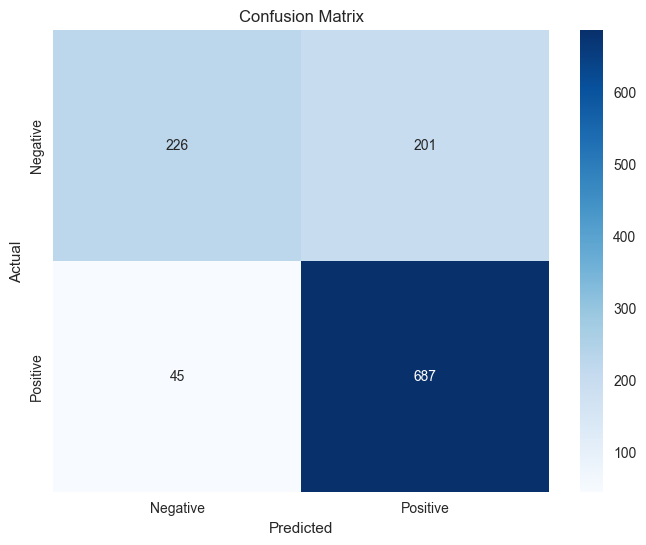

Analyzing stock sentiments...
ticker  mention_count  avg_sentiment  total_sentiment  text_count
    AC              2          1.000                2           2
 ZYNGA              3          1.000                3           3
  ACAD              6          1.000                6           6
   ZOT              4          1.000                4           4
   MOT              2          1.000                2           2
 MOVER              4          1.000                4           4
   MPC              2          1.000                2           2
   MSH              3          1.000                3           3
   MTB              2          1.000                2           2
   MTI              2          1.000                2           2
   MVA              2          1.000                2           2
  MWIV              2          1.000                2           2
  AGNC              3          1.000                3           3
  AISE              2          1.000          

In [20]:
# Initialise model 
analyzer = StockSentimentAnalyzer()

# Train model
accuracy = analyzer.train_model(df)

# Analyse stock sentiments
sentiment_summary = analyzer.analyze_stock_sentiments(df)
print(sentiment_summary.to_string(index=False))

In [21]:
"""
This is a stock recommendation demo and will be integrated in stock dashboard

Column Definitions:
- Ticker: Stock symbol
- Positive: Number of positive mentions
- Negative: Number of negative mentions
- Count: Total mentions
- Sentiment Score: Normalized sentiment (0=negative, 1=positive)
- Confidence: Reliability score based on mention volume and consistency
"""
# Generating Recommendation of Top 5 Stocks(tickers)
recommendations = analyzer.generate_recommendations(sentiment_summary, top_n=5)
print(f'Top 5 Stock Picks\n{recommendations}')

# Save to CSV for dashboard integration
# dashboard_output = recommendations.copy() 
# dashboard_output.to_csv('top5_stock_recommendations.csv', index=False)
# print(f"\nTop 5 recommendations saved to 'top5_stock_recommendations.csv'")


Top 5 Stock Picks
  Ticker  Positive  Negative  Count  Sentiment Score  Confidence
0    AVE        29         0     29              1.0       0.410
1    CUP        28         0     28              1.0       0.409
2    VNG        26         0     26              1.0       0.409
3   SWHC        21         0     21              1.0       0.407
4    ANA        17         0     17              1.0       0.406


# Visualisations 

### Statistics Summary
- Calculating and printing the stats for the top 5 stock recommendations. 
- Displaying the average sentiment score, median confidence level, total mentions, and the ratio of positive to negative mentions for the top 5 stocks.

In [32]:
# Basic Statistics Summary
print("OVERVIEW STATISTICS:")
print("-"*40)
print(f"Average Sentiment Score: {recommendations['Sentiment Score'].mean():.3f}")
print(f"Median Confidence: {recommendations['Confidence'].median():.3f}")
print(f"Total Mentions: {recommendations['Count'].sum()}")
print(f"Positive/Negative Ratio: {recommendations['Positive'].sum() / recommendations['Negative'].sum():.2f}:1\n")

OVERVIEW STATISTICS:
----------------------------------------
Average Sentiment Score: 1.000
Median Confidence: 0.409
Total Mentions: 121
Positive/Negative Ratio: inf:1



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17216\2257882797.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Positive/Negative Ratio: {recommendations['Positive'].sum() / recommendations['Negative'].sum():.2f}:1\n")


### Individual Stock Analysis
- Performing individual stock analysis by iterating over `recommendations`dataframe and printing the following information for each stock:

1. Ticker symbol
2. Bullish consensus (positive mentions / total mentions)
3. Sentiment strength (normalized sentiment score with a neutral score of 0.5)
4. Reliability (confidence score with a maximum value of 1)
5. Sample mentions (up to 2 random text mentions containing the stock ticker)

The code uses the `iterrows()` method to iterate over the rows of the `recommendations` DataFrame, and the `str.contains()` method to filter text mentions containing the stock ticker.

In [31]:
# Individual Stock Analysis
print("STOCK-BY-STOCK ANALYSIS:")
print("-"*40)
for idx, row in recommendations.iterrows():
    print(f"\n{row['Ticker']}:")
    print(f"  - Bullish Consensus: {row['Positive']}/{row['Count']} ({row['Positive']/row['Count']*100:.1f}% positive)")
    print(f"  - Sentiment Strength: {row['Sentiment Score']:.3f} ({(row['Sentiment Score']-0.5)*200:.1f}% above neutral)")
    print(f"  - Reliability: Confidence score of {row['Confidence']:.3f} (1=highest)")
    
    # Get sample mentions
    ticker_mentions = df[df['Text'].str.contains(row['Ticker'])]['Text']
    sample_mentions = ticker_mentions.sample(min(2, len(ticker_mentions)), random_state=42).values if len(ticker_mentions) > 0 else []
    print("  - Sample Mentions:")
    for mention in sample_mentions:
        print(f"    > {mention[:100]}...")

STOCK-BY-STOCK ANALYSIS:
----------------------------------------

AVE:
  - Bullish Consensus: 29/29 (100.0% positive)
  - Sentiment Strength: 1.000 (100.0% above neutral)
  - Reliability: Confidence score of 0.410 (1=highest)
  - Sample Mentions:
    > SK to the GAVE!...
    > user Mr. Florida, hope all is well.  You've trade SAVE in the past, so Im asking you.  Do you like i...

CUP:
  - Bullish Consensus: 28/28 (100.0% positive)
  - Sentiment Strength: 1.000 (100.0% above neutral)
  - Reliability: Confidence score of 0.409 (1=highest)
  - Sample Mentions:

VNG:
  - Bullish Consensus: 26/26 (100.0% positive)
  - Sentiment Strength: 1.000 (100.0% above neutral)
  - Reliability: Confidence score of 0.409 (1=highest)
  - Sample Mentions:
    > VNG getting more 2.80 thats bottom...
    > VNG may go green today and test high 3.29 long today's buy at 3.18...

SWHC:
  - Bullish Consensus: 21/21 (100.0% positive)
  - Sentiment Strength: 1.000 (100.0% above neutral)
  - Reliability: Confidenc

### Comparative Analysis
- Based on sentiment scores, confidence levels, and controversy. 

**Strongest Sentiment**: The stock with the highest sentiment score.
**Most Consistent**: The stock with the highest confidence level.
**Most Controversial**: The stock with the lowest ratio of positive to total mentions.

These metrics are calculated from the `recommendations` DataFrame, which contains columns for sentiment scores, confidence levels, and positive/negative mentions.

In [ ]:
# Comparative Analysis
print("\nCOMPARATIVE ANALYSIS:")
print("-"*40)
strongest = recommendations.loc[recommendations['Sentiment Score'].idxmax()]
most_consistent = recommendations.loc[recommendations['Confidence'].idxmax()]
most_controversial = recommendations.loc[(recommendations['Positive']/recommendations['Count']).idxmin()]

print(f"Strongest Sentiment: {strongest['Ticker']} ({strongest['Sentiment Score']:.3f})")
print(f"Most Consistent: {most_consistent['Ticker']} (Confidence {most_consistent['Confidence']:.3f})")
print(f"Most Controversial: {most_controversial['Ticker']} ({most_controversial['Positive']} positive vs {most_controversial['Negative']} negative)\n")


COMPARATIVE ANALYSIS:
----------------------------------------
Strongest Sentiment: AVE (1.000)
Most Consistent: AVE (Confidence 0.410)
Most Controversial: AVE (29 positive vs 0 negative)



### Risk Assessment
- This code prints a risk assessment of top stock picks based on sentiment analysis. 
- It calculates the percentage of positive and negative mentions for each stock
- Displays a visual representation for positive sentiment and negative sentiment, 
- Along with the percentage of positive sentiment.

In [ ]:
# Risk Assessment
print("RISK ASSESSMENT:")
print("-"*40)
print("Sentiment Distribution Among Top Picks:")
for idx, row in recommendations.iterrows():
    pos_pct = row['Positive']/row['Count']*100
    neg_pct = row['Negative']/row['Count']*100
    print(f"{row['Ticker']}: {'■'*int(pos_pct/5)}{'□'*int(neg_pct/5)} {pos_pct:.1f}% positive")

RISK ASSESSMENT:
----------------------------------------
Sentiment Distribution Among Top Picks:
AVE: ■■■■■■■■■■■■■■■■■■■■ 100.0% positive
CUP: ■■■■■■■■■■■■■■■■■■■■ 100.0% positive
VNG: ■■■■■■■■■■■■■■■■■■■■ 100.0% positive
SWHC: ■■■■■■■■■■■■■■■■■■■■ 100.0% positive
ANA: ■■■■■■■■■■■■■■■■■■■■ 100.0% positive


### Normalised Sentiment Scores (Top 5 Bar Chart)
- **Purpose**  → Rank picks by overall sentiment (0‑1 scale).  
- **Shows**  → All five tickers score **1.0**.  
- **Insight**  → Unanimous bullish consensus → “Strong Buy” candidates.

---

### Confidence Levels (Top 5 Bar Chart)
- **Purpose**  → Gauge reliability via mention volume × sentiment.  
- **Shows**  → Confidence ~ 0.41‑0.40 across picks.  
- **Insight**  → More mentions ⇒ higher trust in sentiment signal.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17216\2817099369.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ticker', y='Sentiment Score', data=recommendations, palette='coolwarm')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17216\2817099369.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ticker', y='Confidence', data=recommendations, palette='Blues_d')


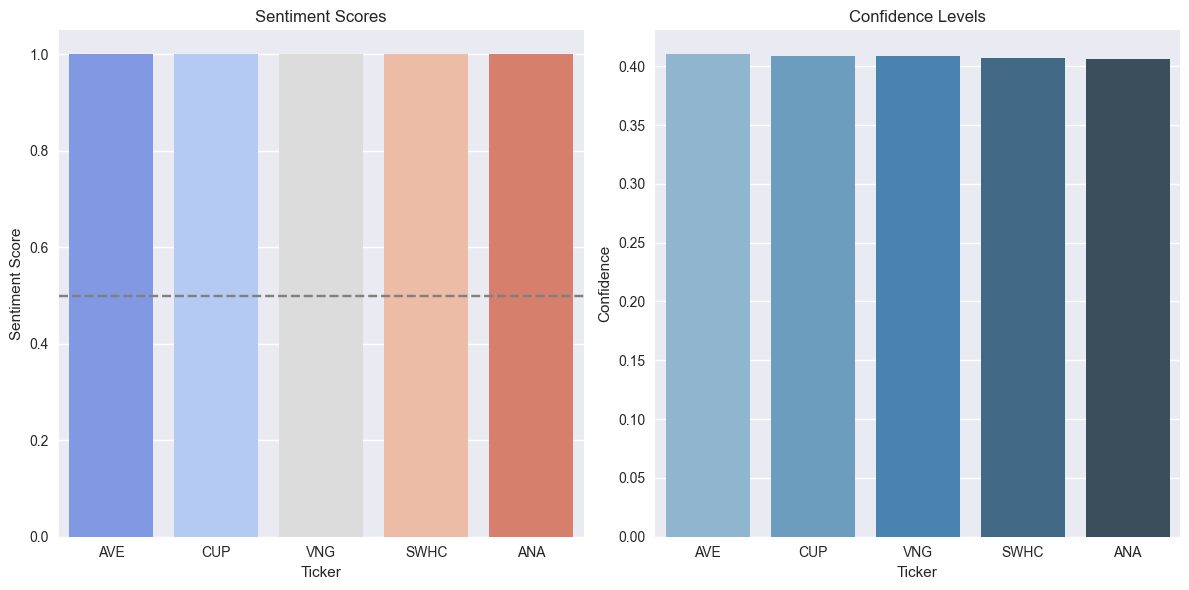

In [22]:

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.barplot(x='Ticker', y='Sentiment Score', data=recommendations, palette='coolwarm')
plt.title('Sentiment Scores')
plt.axhline(0.5, color='grey', linestyle='--')

plt.subplot(1,2,2)
sns.barplot(x='Ticker', y='Confidence', data=recommendations, palette='Blues_d')
plt.title('Confidence Levels')
plt.tight_layout()
plt.show()

### Positive vs Negative Mentions (Stacked Bar)
- **Purpose**  → Reveal sentiment composition for each top stock.  
- **Shows**  → 100 % green (positive) bars, zero red (negative).  
- **Insight**  → No conflicting chatter; further validates bullish stance.

<Figure size 1000x600 with 0 Axes>

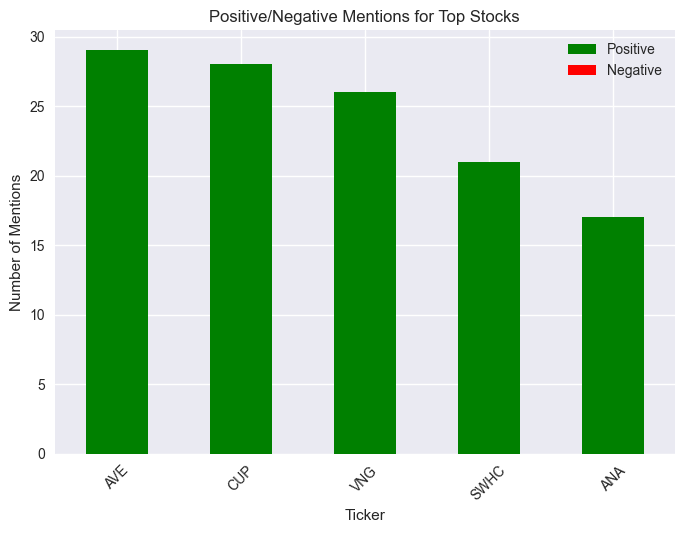

In [23]:
"""Bar Chart of Positive/Negative Mentions"""
plt.figure(figsize=(10,6))
recommendations.set_index('Ticker')[['Positive', 'Negative']].plot(kind='bar', stacked=True, 
                                                                color=['green', 'red'])
plt.title('Positive/Negative Mentions for Top Stocks')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.show()

### Normalised Sentiment Scores (Top 5 Bar Chart)
- **Purpose**  → Rank picks by overall sentiment (0‑1 scale).  
- **Shows**  → All five tickers score **1.0**.  
- **Insight**  → Unanimous bullish consensus → “Strong Buy” candidates.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17216\703091468.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recommendations, x='Ticker', y='Sentiment Score', palette='coolwarm')


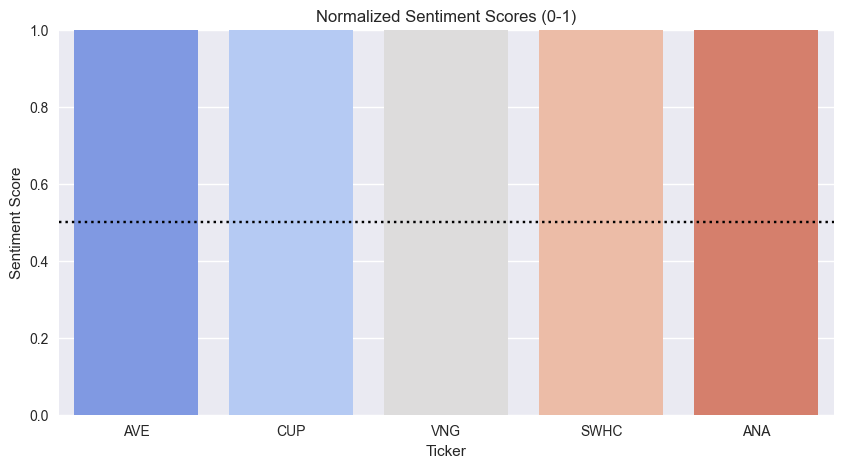

In [24]:
# Normalised Sentiment Scores
plt.figure(figsize=(10,5))
sns.barplot(data=recommendations, x='Ticker', y='Sentiment Score', palette='coolwarm')
plt.axhline(0.5, color='black', linestyle=':')
plt.title('Normalized Sentiment Scores (0-1)')
plt.ylim(0,1)
plt.show()

### Sentiment Distribution (Pie Chart)
- **Purpose**  → Check class balance before modelling.  
- **Shows**  → 63.6 % Positive vs 36.4 % Negative tweets.  
- **Insight**  → Imbalance may bias the classifier; resampling is worth exploring.

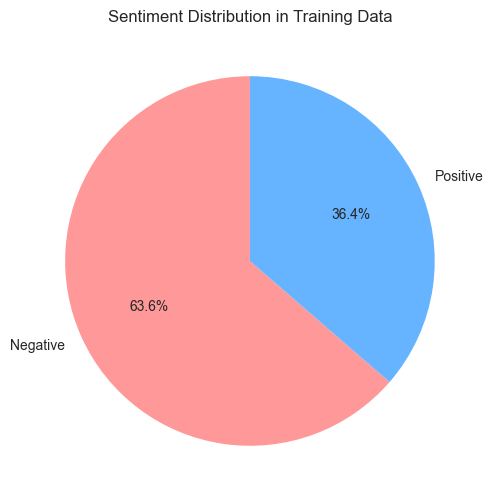

In [25]:
"""Sentiment Distribution Pie Chart"""

# Sentiment distribution in training data
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=['Negative', 'Positive'], 
        autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Sentiment Distribution in Training Data')
plt.show()

### Stock Sentiment vs Mention Frequency (Bubble Chart)
- **Purpose**  → Blend sentiment strength with discussion volume per ticker.  
- **Shows**  → X = Avg Sentiment, Y = Mentions; bubble size = frequency, colour = sentiment.  
- **Insight**  → Large green right‑side bubbles = hyped “buy” signals; large red left‑side = potential “sell” flags.


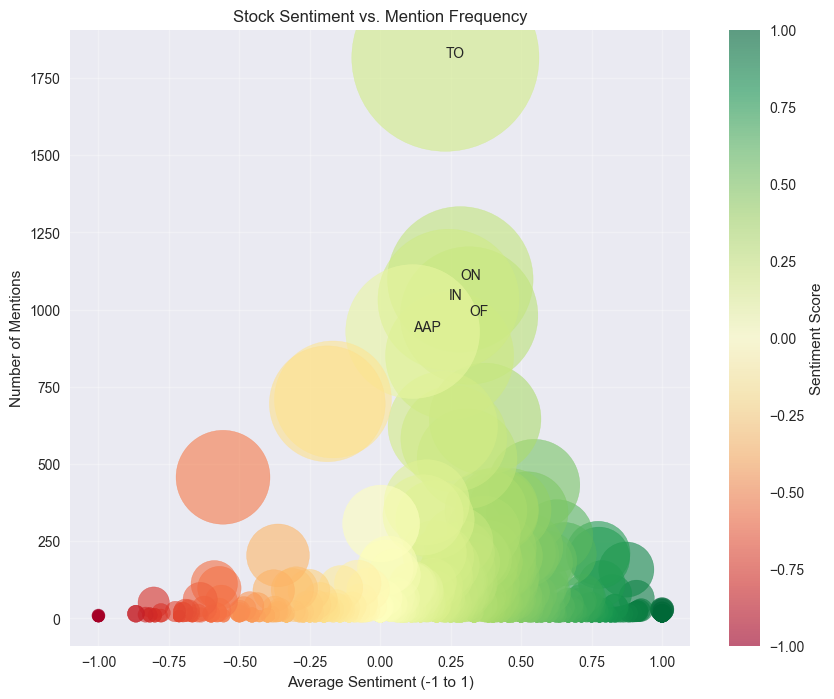

In [26]:
"""Mention Frequency vs. Sentiment (Bubble Chart)"""

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    x=sentiment_summary['avg_sentiment'],
    y=sentiment_summary['mention_count'],
    s=sentiment_summary['mention_count']*10,  # Bubble size
    c=sentiment_summary['avg_sentiment'],
    cmap='RdYlGn',
    alpha=0.6
)

plt.colorbar(label='Sentiment Score')
plt.xlabel('Average Sentiment (-1 to 1)')
plt.ylabel('Number of Mentions')
plt.title('Stock Sentiment vs. Mention Frequency')

# Annotate top stocks
for i, row in sentiment_summary.nlargest(5, 'mention_count').iterrows():
    plt.annotate(row['ticker'], (row['avg_sentiment'], row['mention_count']))
    
plt.grid(True, alpha=0.3)
plt.show()

### Word Clouds (Positive / Negative)
- **Purpose**  → Visual snapshot of dominant tokens per class.  
- **Shows**  → Positive: *today, gain, long* …  Negative: *short, bear, put* …  
- **Insight**  → Confirms tokenisation captures finance‑specific sentiment cues.

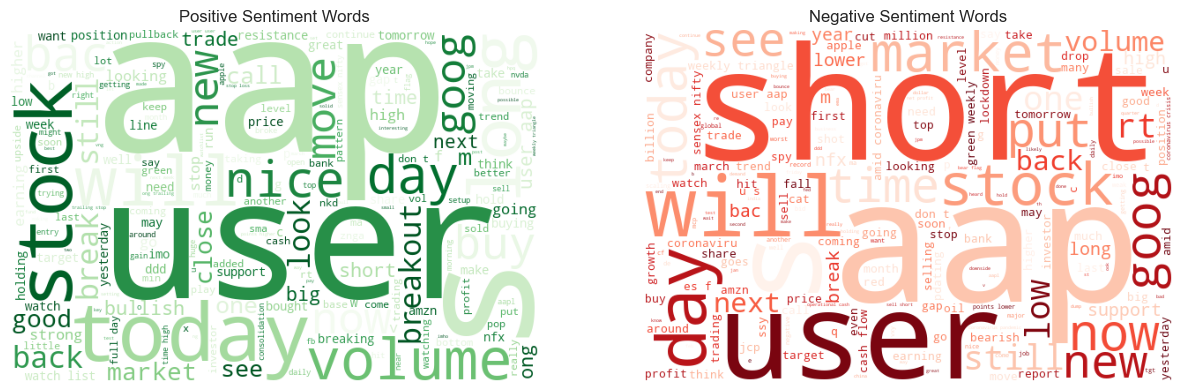

In [27]:
"""Word Clouds for Positive/Negative Sentiments"""

from wordcloud import WordCloud

positive_text = ' '.join(df[df['Sentiment']==1]['cleaned_text'])
negative_text = ' '.join(df[df['Sentiment']==-1]['cleaned_text'])

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
wordcloud = WordCloud(width=600, height=400, background_color='white', 
                      colormap='Greens').generate(positive_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Sentiment Words')

plt.subplot(1,2,2)
wordcloud = WordCloud(width=600, height=400, background_color='white', 
                      colormap='Reds').generate(negative_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Negative Sentiment Words')
plt.show()

### Top Predictive Words (Logistic Regression Coefficients)
- **Purpose**  → Expose features driving model decisions.  
- **Shows**  → 15 highest +ve / ‑ve coefficients.  
- **Insight**  → Pos words (*nice, long*) push predictions up; neg words (*short, lower*) push down—boosting interpretability.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17216\2446073373.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[x[0] for x in top_pos], x=[x[1] for x in top_pos], palette='Greens_d')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17216\2446073373.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[x[0] for x in top_neg], x=[x[1] for x in top_neg], palette='Reds_d')


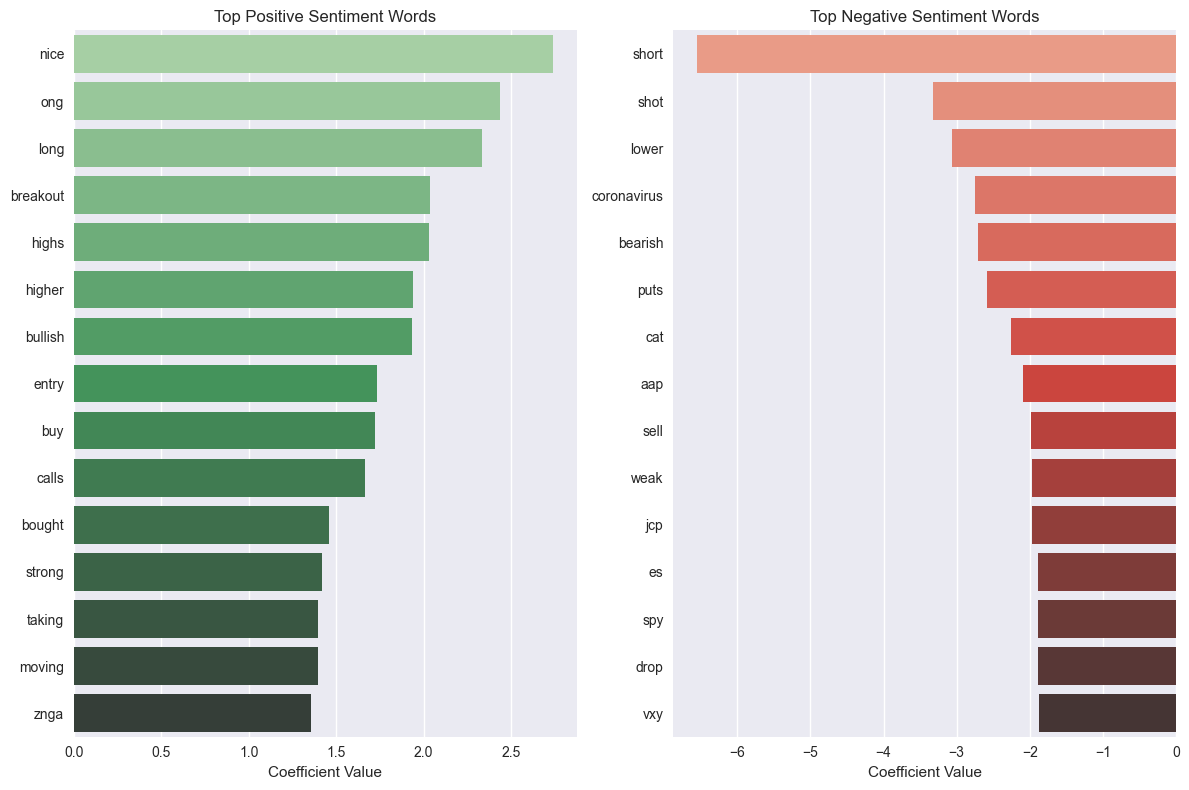

In [28]:
"""Top Predictive Features (Logistic Regression Coefficients)"""

# Get top positive/negative words from the model
feature_names = analyzer.vectorizer.get_feature_names_out()
coefs = analyzer.model.coef_[0]
top_pos = sorted(zip(feature_names, coefs), key=lambda x: x[1], reverse=True)[:15]
top_neg = sorted(zip(feature_names, coefs), key=lambda x: x[1])[:15]

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.barplot(y=[x[0] for x in top_pos], x=[x[1] for x in top_pos], palette='Greens_d')
plt.title('Top Positive Sentiment Words')
plt.xlabel('Coefficient Value')

plt.subplot(1,2,2)
sns.barplot(y=[x[0] for x in top_neg], x=[x[1] for x in top_neg], palette='Reds_d')
plt.title('Top Negative Sentiment Words')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()